In [1]:
# Random Imports
import os
import sys
import yaml
from pathlib import Path
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSegDev')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'

# IonPy imports
from ionpy.util import Config

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
%%yaml default_cfg 

experiment:
  seed: '?' 
  val_first: False 
  torch_compile: True 
  torch_mixed_precision: False
    
dataloader:
  batch_size: '?' 
  num_workers: '?'
  pin_memory: True 

optim: 
  _class: torch.optim.Adam
  lr: '?'
  
train:
  epochs: '?' 
  eval_freq: '?'

# Used for additional data experiment.
data:
  train_kwargs:
    split: 'train'
  val_kwargs: 
    split: 'val'
  
loss_func: 
  _class: '?'
  from_logits: True
  batch_reduction: 'mean' 

<IPython.core.display.Javascript object>

In [3]:
%%yaml log_cfg

log:
  root: '?'
  checkpoint_freq: '?'
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: 'mean' 
      ignore_empty_labels: False 
      from_logits: True

<IPython.core.display.Javascript object>

In [4]:
%%yaml model_cfg  

model:
  _class: ese.models.unet.UNet
  filters: '?'
  convs_per_block: '?' # Good default for UNets.

<IPython.core.display.Javascript object>

In [5]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.callbacks.ShowPredictions
  epoch:
    - ese.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: dice_score
        phase: val

<IPython.core.display.Javascript object>

In [6]:
%%yaml aug_cfg

augmentations:
    spatial:
        max_translation: 5.0
        max_rotation: 5.0
        max_scaling: 1.1
        warp_integrations: 5
        warp_smoothing_range: [10, 20]
        warp_magnitude_range: [1, 3]
        affine_probability: 0.5
        warp_probability: 0.5
    # visual:
    #     use_mask: False 
    #     added_noise_max_sigma: 0.01
    #     gamma_scaling_max: 0.1
    #     bias_field_probability: 0.5
    #     gamma_scaling_probability: 0.5
    #     added_noise_probability: 0.5

<IPython.core.display.Javascript object>

In [7]:
%%yaml experiment_cfg 

group: "ISLES_PropEstimationExp"

experiment:
    seed: 40
    seed_range: 1
    torch_compile: False 

data:
    _class: "ese.datasets.ISLES"

optim:
    lr: 1.0e-4 

dataloader:
    batch_size: 1
    num_workers: 1

loss_func:
    _class: 
        - ese.losses.PixelCELoss
        - ese.losses.SoftDiceLoss

<IPython.core.display.Javascript object>

In [8]:
from ese.analysis.analysis_utils.submit_utils import get_ese_training_configs 

# Get the configs for the different runs.
# base_cfg = Config(default_cfg).update([model_cfg, log_cfg, callbacks_cfg])
base_cfg = Config(default_cfg).update([model_cfg, log_cfg, callbacks_cfg, aug_cfg])

# Get the different experiment cfg yamls.
updated_base_cfg, train_cfgs = get_ese_training_configs(
    exp_cfg=experiment_cfg, 
    base_cfg=base_cfg
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [9]:
len(train_cfgs)

2

## Running Jobs

Set seed: 40


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Running CalibrationExperiment("/storage/vbutoi/scratch/ESE/training/debug/20241110_183202-JZVQ-ebc376acf14fbc95a4e26572d9c7b747")
---
augmentations:
  spatial:
    affine_probability: 0.5
    max_rotation: 5.0
    max_scaling: 1.1
    max_translation: 5.0
    warp_integrations: 5
    warp_magnitude_range:
    - 1
    - 3
    warp_probability: 0.5
    warp_smoothing_range:
    - 10
    - 20
callbacks:
  epoch:
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: dice_score
      phase: val
  step:
  - ese.callbacks.ShowPredictions
data:
  _class: ese.datasets.ISLES
  train_kwargs:
    split: train
  val_kwargs:
    split: val
  version: 1.0
dataloader:
  batch_size: 1
  num_workers: 1
  pin_memory: true
experiment:
  seed: 40
  torch_compile: false
  torch_mixed_precision: false
  val_first: false
log:
  checkpoint_freq: 30
  metrics:
    dice_score:
      _fn: ionpy

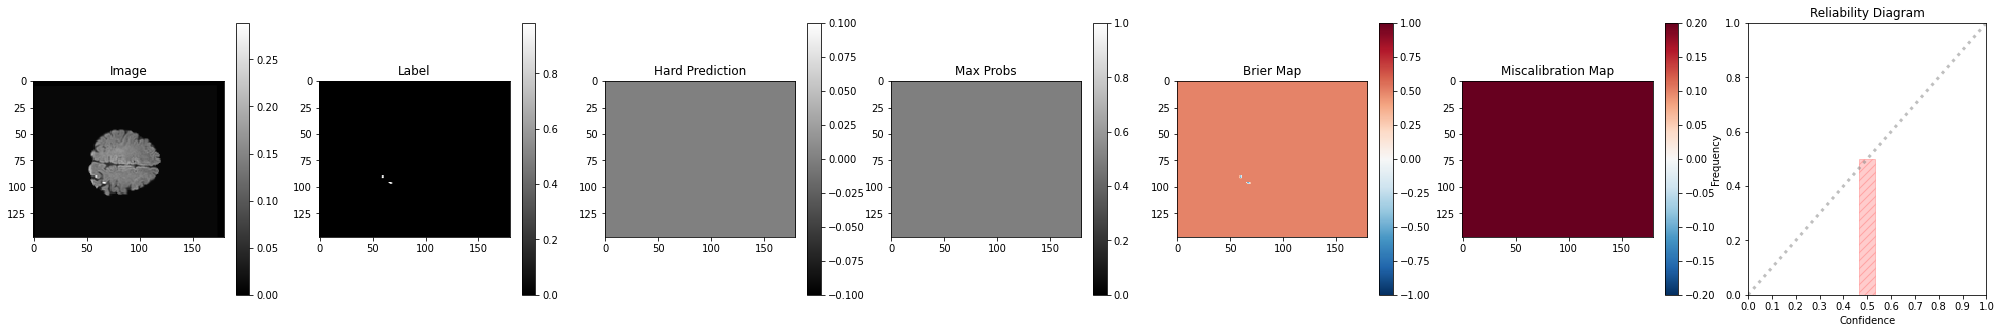

y_pred_estimate torch.Size([1, 1])
y_pred shape torch.Size([1, 1, 148, 180, 71])
y_true_estimate torch.Size([1, 1])
y_true shape torch.Size([1, 1, 148, 180, 71])


NotImplementedError: Proportion is not implemented yet.

In [10]:
####### FOR DEBUGGIN
from ese.experiment import run_ese_exp, CalibrationExperiment

run_ese_exp(
    config=train_cfgs[0], 
    experiment_class=CalibrationExperiment,
    run_name='debug',
    show_examples=True,
    track_wandb=False,
    gpu='0',
)

In [ ]:
# # FOR SUBMISSION
# from ese.experiment import submit_ese_exps, CalibrationExperiment 

# submit_ese_exps(
#     group="training",
#     base_cfg=updated_base_cfg,
#     exp_cfg=experiment_cfg,
#     config_list=train_cfgs,
#     experiment_class=CalibrationExperiment,
#     track_wandb=True,
#     available_gpus=['0', '1', '2', '3'],
# )